In [1]:
import h5py
from collections import defaultdict
import random
import numpy as np
import pickle
import os

In [2]:
file_path = "../data/merge.hdf5"


hdf5_file = h5py.File(file_path, 'r')
data_group = hdf5_file['data']

In [3]:
sample_key = list(data_group.keys())[0]
sample = data_group[sample_key]

print("Attributes in sample : ",dict(sample.attrs))
print("Key : ",sample_key)

Attributes in sample :  {'back_azimuth_deg': 159.3, 'coda_end_sample': array([[2896.]], dtype=float32), 'network_code': 'TA', 'p_arrival_sample': 700.0, 'p_status': 'manual', 'p_travel_sec': 17.079999923706055, 'p_weight': 0.5, 'receiver_code': '109C', 'receiver_elevation_m': 150.0, 'receiver_latitude': 32.8889, 'receiver_longitude': -117.1051, 'receiver_type': 'BH', 's_arrival_sample': 1894.0, 's_status': 'manual', 's_weight': 0.5, 'snr_db': array([56.79999924, 55.40000153, 47.40000153]), 'source_depth_km': 0.45, 'source_depth_uncertainty_km': 'None', 'source_distance_deg': 0.92, 'source_distance_km': 102.09, 'source_error_sec': 1.1119, 'source_gap_deg': 107.466, 'source_horizontal_uncertainty_km': 4.6403, 'source_id': '8556349', 'source_latitude': 33.7496, 'source_longitude': -117.4938, 'source_magnitude': 3.6, 'source_magnitude_author': 'None', 'source_magnitude_type': 'ml', 'source_mechanism_strike_dip_rake': 'None', 'source_origin_time': '2006-07-23 15:58:50.88', 'source_origin_un

In [4]:
attrs = sample.attrs
print("Label:", attrs['trace_category'])
print("Reciever code : ",attrs['receiver_code'])

Label: earthquake_local
Reciever code :  109C


In [5]:
earthquake_keys = np.load("../preprocessed/earthquake_keys.npy", allow_pickle=True)
noise_keys = np.load("../preprocessed/noise_keys.npy", allow_pickle=True)
subset_keys = np.concatenate([earthquake_keys, noise_keys])

print(f"Total subset keys: {len(subset_keys)}")

Total subset keys: 70000


In [ ]:
key_to_label = {}
station_to_keys = defaultdict(list)

for key in subset_keys:
    attrs = data_group[key].attrs
    label = 1 if attrs["trace_category"] == "earthquake_local" else 0
    station = attrs["receiver_code"]
    key_to_label[key] = label
    station_to_keys[station].append(key)

print(f"Total stations in subset: {len(station_to_keys)}")

with open("../preprocessed/key_to_label.pkl", "wb") as f:
    pickle.dump(key_to_label, f)

with open("../preprocessed/station_to_keys.pkl", "wb") as f:
    pickle.dump(station_to_keys, f)

In [6]:
with open("../preprocessed/key_to_label.pkl", "rb") as f:
    key_to_label = pickle.load(f)

with open("../preprocessed/station_to_keys.pkl", "rb") as f:
    station_to_keys = pickle.load(f)

##### Splitting Train , Val , Test data based on Stations

In [80]:
stations = list(station_to_keys.keys())
random.seed(40)
random.shuffle(stations)

n_total = len(stations)
n_train = int(0.8 * n_total)
n_val = int(0.1 * n_total)

train_stations = stations[:n_train]
val_stations = stations[n_train:n_train + n_val]
test_stations = stations[n_train + n_val:]

In [81]:
def collect_samples(station_list):
  return np.array([
    (key, key_to_label[key])
    for st in station_list
    for key in station_to_keys[st]
  ], dtype=object)

train_samples = collect_samples(train_stations)
val_samples   = collect_samples(val_stations)
test_samples  = collect_samples(test_stations)

print(train_samples.shape)
print(val_samples.shape)
print(test_samples.shape)

(55266, 2)
(7420, 2)
(7314, 2)


In [82]:
np.save("../preprocessed/train_split.npy", train_samples)
np.save("../preprocessed/val_split.npy", val_samples)
np.save("../preprocessed/test_split.npy", test_samples)

In [7]:
train_samples = np.load("../preprocessed/train_split.npy",allow_pickle=True)
val_samples = np.load("../preprocessed/val_split.npy",allow_pickle=True)
test_samples = np.load("../preprocessed/test_split.npy",allow_pickle=True)

print(train_samples.shape)
print(val_samples.shape)
print(test_samples.shape)

(55266, 2)
(7420, 2)
(7314, 2)


In [84]:
from scipy.signal import stft
from tqdm import tqdm


os.makedirs("../preprocessed/spectrograms", exist_ok=True)

# STFT parameters
fs = 100  # Hz (STEAD sampling rate)
nperseg = 128
noverlap = 64
nfft = 128

def preprocess_sample(hdf5_file, key):
    sample = hdf5_file['data'][key][:]
    sample = (sample - sample.mean(axis=0)) / (sample.std(axis=0) + 1e-6)

    specs = []
    for ch in range(3):
        f, t, Zxx = stft(sample[:, ch], fs=fs, nperseg=nperseg,
                         noverlap=noverlap, nfft=nfft)
        Sxx = np.abs(Zxx)
        Sxx = (Sxx - Sxx.min()) / (Sxx.max() - Sxx.min() + 1e-6)
        specs.append(Sxx)

    return np.stack(specs, axis=-1).astype(np.float32)

def preprocess_split(split_name):
    samples = np.load(f"../preprocessed/{split_name}_split.npy", allow_pickle=True)
    X_list, y_list = [], []
    with h5py.File(file_path, "r") as f:
        for i, (key, label) in enumerate(tqdm(samples, desc=f"{split_name} processing")):
            spec = preprocess_sample(f, key)
            X_list.append(spec)
            y_list.append(label)

    X = np.array(X_list)
    y = np.array(y_list)
    np.save(f"../preprocessed/spectrograms/X_{split_name}.npy", X)
    np.save(f"../preprocessed/spectrograms/y_{split_name}.npy", y)
    print(f"{split_name} saved: {X.shape}, {y.shape}")


preprocess_split("train")
preprocess_split("val")
preprocess_split("test")


train processing: 100%|██████████| 55266/55266 [25:04<00:00, 36.75it/s]


train saved: (55266, 65, 95, 3), (55266,)


val processing: 100%|██████████| 7420/7420 [03:39<00:00, 33.79it/s]


val saved: (7420, 65, 95, 3), (7420,)


test processing: 100%|██████████| 7314/7314 [02:56<00:00, 41.48it/s]


test saved: (7314, 65, 95, 3), (7314,)


In [8]:
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.metrics import classification_report, confusion_matrix

In [9]:
X_train = np.load("../preprocessed/spectrograms/X_train.npy")
y_train = np.load("../preprocessed/spectrograms/y_train.npy")
X_val = np.load("../preprocessed/spectrograms/X_val.npy")
y_val = np.load("../preprocessed/spectrograms/y_val.npy")
X_test = np.load("../preprocessed/spectrograms/X_test.npy")
y_test = np.load("../preprocessed/spectrograms/y_test.npy")

In [10]:
print(f"Train: {X_train.shape}, Val: {X_val.shape}, Test: {X_test.shape}")

Train: (55266, 65, 95, 3), Val: (7420, 65, 95, 3), Test: (7314, 65, 95, 3)


In [11]:
data_augmentation = tf.keras.Sequential([
    layers.RandomTranslation(height_factor=0.03, width_factor=0.05),
    layers.RandomZoom(0.05),
    layers.RandomContrast(0.2),
    layers.Lambda(lambda x: x + tf.random.normal(tf.shape(x), stddev=0.02))
])

In [12]:
BATCH_SIZE = 32

def make_dataset(X,y,training=False):
  dataset = tf.data.Dataset.from_tensor_slices((X,y))
  if training:
    dataset = dataset.shuffle(buffer_size=2000)
    dataset = dataset.map(lambda x,y : (data_augmentation(x,training=True),y),
                          num_parallel_calls=tf.data.AUTOTUNE)
  dataset = dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
  return dataset

In [13]:
train_ds = make_dataset(X_train, y_train, training=True)
val_ds = make_dataset(X_val, y_val)
test_ds = make_dataset(X_test, y_test)

In [14]:
for batch_x, batch_y in train_ds.take(1):
  print("Batch X shape:", batch_x.shape)
  print("Batch Y shape:", batch_y.shape)
  break

Batch X shape: (32, 65, 95, 3)
Batch Y shape: (32,)


In [15]:
def build_cnn(input_shape):
    model = models.Sequential([
        layers.Input(shape=input_shape),

        layers.Conv2D(16, (3,3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2,2)),

        layers.Conv2D(32, (3,3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2,2)),

        layers.Conv2D(64, (3,3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.GlobalAveragePooling2D(),

        layers.Dense(64, activation='relu'),
        layers.Dropout(0.4),
        layers.Dense(1, activation='sigmoid')
    ])
    return model

model = build_cnn(X_train.shape[1:])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 65, 95, 16)        448       
                                                                 
 batch_normalization (BatchN  (None, 65, 95, 16)       64        
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 47, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 47, 32)        4640      
                                                                 
 batch_normalization_1 (Batc  (None, 32, 47, 32)       128       
 hNormalization)                                                 
                                                      

In [16]:
from tensorflow.keras import callbacks

early_stop = callbacks.EarlyStopping(
    monitor='val_loss', patience=5, restore_best_weights=True
)

In [17]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=25,               
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/25
1728/1728 [==============================] - 34s 16ms/step - loss: 0.0991 - accuracy: 0.9653 - val_loss: 0.4480 - val_accuracy: 0.8511
Epoch 2/25
1728/1728 [==============================] - 29s 17ms/step - loss: 0.0559 - accuracy: 0.9822 - val_loss: 0.0341 - val_accuracy: 0.9891
Epoch 3/25
1728/1728 [==============================] - 30s 17ms/step - loss: 0.0430 - accuracy: 0.9865 - val_loss: 0.0250 - val_accuracy: 0.9918
Epoch 4/25
1728/1728 [==============================] - 30s 18ms/step - loss: 0.0367 - accuracy: 0.9887 - val_loss: 0.0234 - val_accuracy: 0.9919
Epoch 5/25
1728/1728 [==============================] - 46s 26ms/step - loss: 0.0324 - accuracy: 0.9893 - val_loss: 2.1832 - val_accuracy: 0.7504
Epoch 6/25
1728/1728 [==============================] - 33s 19ms/step - loss: 0.0265 - accuracy: 0.9917 - val_loss: 0.0511 - val_accuracy: 0.9845
Epoch 7/25
1728/1728 [==============================] - 33s 19ms/step - loss: 0.0248 - accuracy: 0.9924 - val_loss: 0.0380 -

In [18]:
test_loss, test_acc = model.evaluate(test_ds)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")

229/229 [==============================] - 2s 9ms/step - loss: 0.0141 - accuracy: 0.9975
Test Loss: 0.0141
Test Accuracy: 0.9975


In [24]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

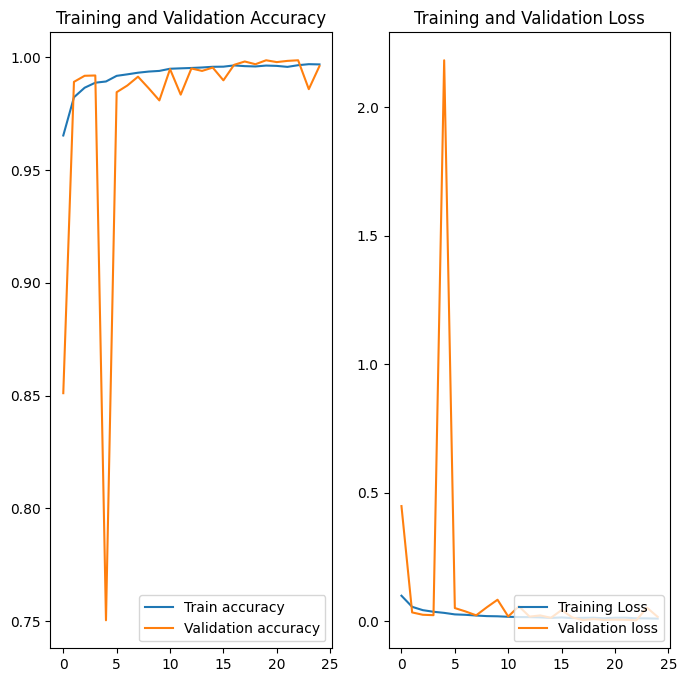

In [29]:
import matplotlib.pyplot as plt
epochs_ran = len(history.history['accuracy'])

plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(epochs_ran),history.history['accuracy'],label='Train accuracy')
plt.plot(range(epochs_ran),history.history['val_accuracy'],label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.legend(loc='lower right')

plt.subplot(1,2,2)
plt.plot(range(epochs_ran),history.history['loss'],label='Training Loss')
plt.plot(range(epochs_ran),history.history['val_loss'],label='Validation loss')
plt.title('Training and Validation Loss')
plt.legend(loc='lower right')
plt.show()

In [30]:
y_pred_probs = model.predict(test_ds)
y_pred = (y_pred_probs > 0.5).astype(int)


y_true = np.concatenate([y for x, y in test_ds], axis=0)


print(classification_report(y_true, y_pred, target_names=["Noise","Earthquake"]))


cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:\n", cm)

229/229 [==============================] - 1s 3ms/step
              precision    recall  f1-score   support

       Noise       1.00      1.00      1.00      3111
  Earthquake       1.00      1.00      1.00      4203

    accuracy                           1.00      7314
   macro avg       1.00      1.00      1.00      7314
weighted avg       1.00      1.00      1.00      7314

Confusion Matrix:
 [[3106    5]
 [  13 4190]]


In [32]:
model.save("../models/cnn_baseline_model")

INFO:tensorflow:Assets written to: ../models/cnn_baseline_model\assets


INFO:tensorflow:Assets written to: ../models/cnn_baseline_model\assets
